<a href="https://colab.research.google.com/github/Edenshmuel/PapaJohns_Data_Science_Project/blob/main/DeepAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Final_Project_PapaJohns/cleaned_data.csv')

In [45]:
desc_encoding_map = pd.read_csv('/content/drive/MyDrive/Final_Project_PapaJohns/Desc_encoding_map.csv')

desc_encoding_map.columns = ['Description', 'Clean_Desc_Encoded']
desc_encoding_map["Clean_Desc_Encoded"] = desc_encoding_map["Clean_Desc_Encoded"].astype(int)

In [1]:
!pip install pip==23.2.1

In [3]:
# !pip install gluonts==0.10.7 mxnet==1.8.0.post0

  Obtaining dependency information for gluonts==0.10.7 from https://files.pythonhosted.org/packages/b8/a9/b0ad9d1d0df70e269b68a4fa373b59e379054d6134146c494e252f1637a1/gluonts-0.10.7-py3-none-any.whl.metadata
  Obtaining dependency information for mxnet==1.8.0.post0 from https://files.pythonhosted.org/packages/30/07/66174e78c12a3048db9039aaa09553e35035ef3a008ba3e0ed8d2aa3c47b/mxnet-1.8.0.post0-py2.py3-none-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pandas~=1.0 from https://files.pythonhosted.org/packages/56/73/3351beeb807dca69fcc3c4966bcccc51552bd01549a9b13c04ab00a43f21/pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pydantic~=1.7 from https://files.pythonhosted.org/packages/a4/f0/424ad837746e69e9f061ba9be68c2a97aef7376d1911692904d8efbcd322/pydantic-1.10.22-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 3.3

In [2]:
!pip install gluonts==0.10.7 mxnet==1.8.0.post0 numpy==1.23 scipy==1.9.3

  Using cached numpy-1.23.0-cp311-cp311-linux_x86_64.whl
INFO: pip is looking at multiple versions of pandas to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for pandas~=1.0 from https://files.pythonhosted.org/packages/b6/ba/a5ed09e4044c683fab1dec7a18fb139db0afde61def7a4d8fa2848a2d9c8/pandas-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pandas~=1.0 from https://files.pythonhosted.org/packages/1e/a6/14bd623f06a05b551cdb51cc2ec8cbe3af8a6928fe0b8b5ffc6b4c5423fa/pandas-1.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 52.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    U

In [2]:
# !pip install numpy==1.23 scipy==1.9.3

  Using cached numpy-1.23.0.tar.gz (10.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached scipy-1.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
Using cached scipy-1.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (33.4 MB)
  Created wheel for numpy: filename=numpy-1.23.0-cp311-cp311-linux_x86_64.whl size=19730136 sha256=295278ed41e833ce4a92d9b6f51c2271505c3b69cddd82dbd114033ab5ba19f4
  Stored in directory: /root/.cache/pip/wheels/6d/36/1a/3ec6b85008bea3151efb003f5d41baa7bf4966cb43c1c2470b
Successfully built numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
import numpy as np

In [6]:
from datetime import datetime
start_input = input("הזן תאריך התחלה לחיזוי (YYYY-MM-DD): ")
end_input   = input("הזן תאריך סיום לחיזוי   (YYYY-MM-DD): ")
start_date = pd.to_datetime(start_input)
end_date   = pd.to_datetime(end_input)

today = pd.to_datetime(datetime.today().date())
range_days = (end_date - start_date).days + 1

if start_date <= today:
    raise ValueError("⛔ תאריך ההתחלה חייב להיות מחר או מאוחר יותר.")
if end_date < start_date:
    raise ValueError("⛔ תאריך הסיום חייב להיות אחרי תאריך ההתחלה.")
if range_days < 7:
    raise ValueError("⛔ טווח התחזית חייב להיות לפחות 7 ימים.")
if range_days > 31:
    raise ValueError("⛔ טווח התחזית חייב להיות עד 31 ימים בלבד.")

הזן תאריך התחלה לחיזוי (YYYY-MM-DD): 2025-07-29
הזן תאריך סיום לחיזוי   (YYYY-MM-DD): 2025-08-20


In [7]:
def generate_forecast_series(
        df,
        start_date,
        end_date,
        dynamic_features_cols,
        item_col="Clean_Desc_Encoded",
        target_col="Quantity",
        freq="D"):

    prediction_length = (end_date - start_date).days + 1
    series_list = []

    for item_id in df[item_col].unique():
        df_item = df[df[item_col] == item_id].copy()

        # --- 1) real historical data only --------------------------
        df_hist = df_item[df_item["Date"] < start_date].sort_values("Date")
        if df_hist.empty:
            continue

        # --- 2) full range (past + future) for dynamic features -------
        full_dates = pd.date_range(
            start=df_hist["Date"].iloc[0],
            end=end_date,
            freq=freq
        )
        df_full = pd.DataFrame({"Date": full_dates})
        df_full[item_col] = item_id
        cols_to_merge = [c for c in df_item.columns if c not in [target_col]]
        df_full = (
            df_full
            .merge(df_item[cols_to_merge], on=["Date", item_col], how="left")
            .sort_values("Date")
        )

        target_hist = df_hist[target_col].astype(float).values

        df_full["Year"]  = df_full["Date"].dt.year
        df_full["Month"] = df_full["Date"].dt.month
        df_full["Day"]   = df_full["Date"].dt.day
        df_full["WeekOfYear"] = df_full["Date"].dt.isocalendar().week
        df_full["Day_Name"]   = df_full["Date"].dt.day_name()

        df_full["is_weekend"]        = (df_full["Date"].dt.dayofweek >= 5).astype(int)
        df_full["is_start_of_month"] = df_full["Date"].dt.is_month_start.astype(int)
        df_full["is_end_of_month"]   = df_full["Date"].dt.is_month_end.astype(int)

        df_full["Day_Name_sin"] = np.sin(2 * np.pi * df_full["Date"].dt.dayofweek / 7)
        df_full["Day_Name_cos"] = np.cos(2 * np.pi * df_full["Date"].dt.dayofweek / 7)
        df_full["Month_sin"]    = np.sin(2 * np.pi * df_full["Month"] / 12)
        df_full["Month_cos"]    = np.cos(2 * np.pi * df_full["Month"] / 12)

        for col in dynamic_features_cols:
            if col not in df_full.columns:
                df_full[col] = 0
            df_full[col] = (df_full[col]
                            .fillna(method="ffill")
                            .fillna(method="bfill")
                            .fillna(0))
        feat_dynamic_real = df_full[dynamic_features_cols].T.values.tolist()

        # --- 3) record for time series -----------------------------------
        series_list.append(
            {
                "start": df_hist["Date"].iloc[0],
                "target": target_hist,
                "feat_dynamic_real": feat_dynamic_real,
                "item_id": str(item_id),
            }
        )

    return series_list, prediction_length

In [49]:
df["Date"] = pd.to_datetime(df["Date"])

In [9]:
#List of dynamic features
dynamic_features_cols = [
    'Year', 'Month', 'Day', 'Is_Weekend',
    'is_christian_holiday', 'is_jewish_holiday',
    'is_near_jewish_holiday', 'is_day_before_new_year',
    'category_encoded', 'WeekOfYear', 'Season',
    'is_start_of_month', 'is_end_of_month',
    'Day_Name_sin', 'Day_Name_cos', 'Month_sin', 'Month_cos',
    'encoded_jewish_holiday', 'encoded_christian_holiday'
]

columns_to_drop_dynamic = [
    'portion_type',
    'avg_quantity_all_time',
    'std_quantity_all_time',
    'num_days_sold',
    'popularity_score'
]

dynamic_features_cols = [
    col for col in dynamic_features_cols if col not in columns_to_drop_dynamic]

# Filtering categories with less than 50 sales
filtered_df = (
    df.groupby("Clean_Desc_Encoded")
    .filter(lambda g: len(g) >= 50))

series_list, prediction_length = generate_forecast_series(
    df=filtered_df,
    start_date=start_date,
    end_date=end_date,
    dynamic_features_cols=dynamic_features_cols)

training_ds = ListDataset(series_list, freq="D")
test_ds = ListDataset(series_list, freq="D")

In [10]:
estimator = DeepAREstimator(
    freq="D",
    prediction_length=prediction_length,
    context_length=prediction_length * 6,
    cell_type="gru",
    num_layers=2,
    trainer=Trainer(ctx="cpu", epochs=50, learning_rate=1e-3, weight_decay=1e-5))

predictor = estimator.train(training_ds)

100%|██████████| 50/50 [00:17<00:00,  2.85it/s, epoch=50/50, avg_epoch_loss=-0.197]


In [86]:
test_ds = ListDataset(series_list, freq="D")

forecasts = {}

for entry, forecast in zip(test_ds, predictor.predict(test_ds)):
    cat_id = entry["item_id"]
    forecast_index = pd.date_range(start=start_date, periods=prediction_length, freq="D")

    df_forecast = pd.DataFrame({
        "date": forecast_index,
        "predicted_quantity": forecast.quantile(0.9)
    })

    df_forecast["predicted_quantity_ceiled"] = np.round(df_forecast["predicted_quantity"])
    forecasts[cat_id] = df_forecast

all_forecasts_list = []

for cat_id, df_cat in forecasts.items():
    df_cat["clean_desc_encoded"] = int(cat_id)
    all_forecasts_list.append(df_cat)

all_forecasts_df = pd.concat(all_forecasts_list, ignore_index=True)
desc_encoding_map.columns = ["desc_name", "clean_desc_encoded"]
all_forecasts_df = all_forecasts_df.merge(desc_encoding_map, on="clean_desc_encoded", how="left")
all_forecasts_df["predicted_quantity_ceiled"] = np.round(all_forecasts_df["predicted_quantity"])

all_forecasts_df.sort_values(["clean_desc_encoded", "date"]).head(30)

,date,predicted_quantity,predicted_quantity_ceiled,clean_desc_encoded,desc_name
0,2025-07-29,1.013657,1.0,0,ביאנקה 14
1,2025-07-30,1.021604,1.0,0,ביאנקה 14
2,2025-07-31,1.014261,1.0,0,ביאנקה 14
3,2025-08-01,1.013020,1.0,0,ביאנקה 14
4,2025-08-02,1.011318,1.0,0,ביאנקה 14
5,2025-08-03,1.007509,1.0,0,ביאנקה 14
6,2025-08-04,1.014439,1.0,0,ביאנקה 14
7,2025-08-05,1.014295,1.0,0,ביאנקה 14
8,2025-08-06,1.010886,1.0,0,ביאנקה 14
9,2025-08-07,1.018469,1.0,0,ביאנקה 14


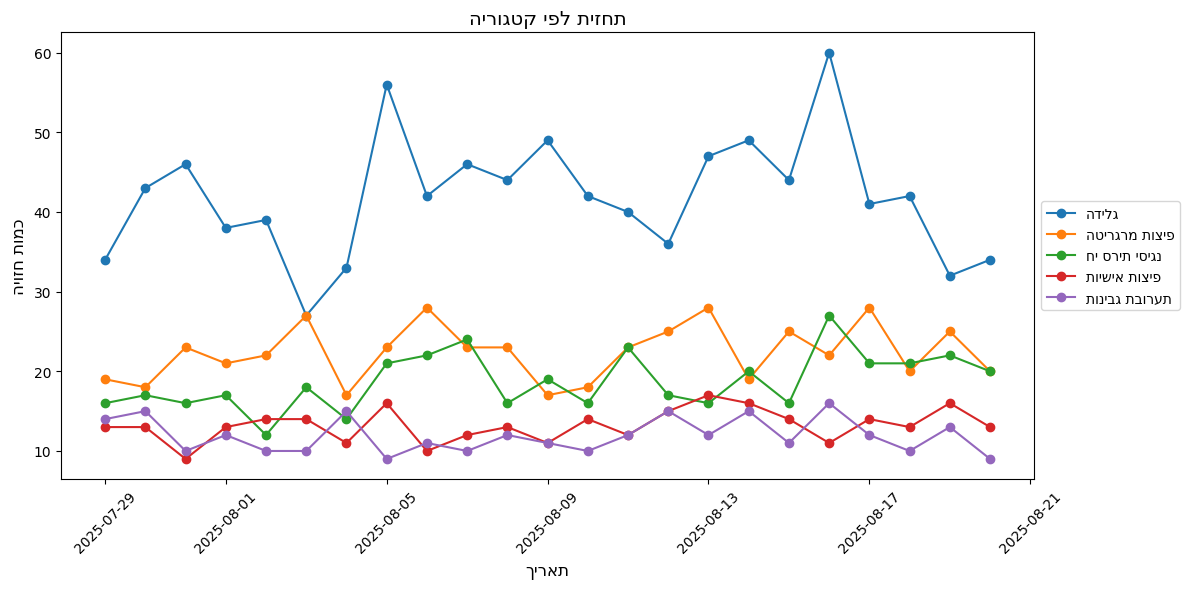

In [87]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

desc_name_map = desc_encoding_map.set_index("clean_desc_encoded")["desc_name"].to_dict()

top_ids = (
    all_forecasts_df.groupby("clean_desc_encoded")["predicted_quantity_ceiled"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist())

plt.rcParams['font.family'] = 'DejaVu Sans'

plt.figure(figsize=(12, 6))

for cat_id in top_ids:
    df_plot = forecasts[str(cat_id)]
    cat_name = desc_name_map.get(cat_id, f"קטגוריה {cat_id}")

    cat_name_rtl = cat_name[::-1]

    plt.plot(df_plot["date"], df_plot["predicted_quantity_ceiled"], marker='o', label=cat_name_rtl)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("תחזית לפי קטגוריה"[::-1], fontsize=14)
plt.xlabel("תאריך"[::-1], fontsize=12)
plt.ylabel("כמות חזויה"[::-1], fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [88]:
# Define evaluation date ranges
train_end_date_eval = pd.to_datetime("2024-09-30")
test_start_date_eval = pd.to_datetime("2024-10-01")
test_end_date_eval = pd.to_datetime("2024-10-23")

# Calculate prediction length (number of forecast days)
prediction_length_eval = (test_end_date_eval - test_start_date_eval).days + 1

# Generate input series for evaluation based on historical data and future window
series_list_eval, prediction_length_eval = generate_forecast_series(
    df=df[df["Date"] <= train_end_date_eval],
    start_date=test_start_date_eval,
    end_date=test_end_date_eval,
    dynamic_features_cols=dynamic_features_cols
)

# Wrap the series in a GluonTS-compatible dataset
test_ds_eval = ListDataset(series_list_eval, freq="D")

# Dictionary to store forecast DataFrames for each item
forecasts_eval = {}

# Run prediction for each series and build a forecast DataFrame
for entry, forecast in zip(test_ds_eval, predictor.predict(test_ds_eval)):
    cat_id = entry["item_id"]
    forecast_index = pd.date_range(
        start=test_start_date_eval,
        periods=prediction_length_eval,
        freq="D"
    )

    forecasts_eval[cat_id] = pd.DataFrame({
        "date": forecast_index,
        "predicted_quantity": forecast.quantile(0.9),
        "Clean_Desc_Encoded": int(cat_id)})

# Combine all item forecasts into a single DataFrame
all_forecasts_eval_list = list(forecasts_eval.values())
all_forecasts_eval_df = pd.concat(all_forecasts_eval_list, ignore_index=True)

In [89]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

all_forecasts_eval_df["predicted_quantity_ceiled"] = np.round(all_forecasts_eval_df["predicted_quantity"])

eval_df = (
    all_forecasts_eval_df
    .merge(
        df[["Date", "Clean_Desc_Encoded", "Quantity"]],
        left_on=["date", "Clean_Desc_Encoded"],
        right_on=["Date", "Clean_Desc_Encoded"],
        how="inner"
    )
    .rename(columns={"Quantity": "Actual", "predicted_quantity_ceiled": "Predicted"})
)

eval_df = eval_df[eval_df["Actual"] > 0].dropna(subset=["Predicted"])

y_true = eval_df["Actual"].reset_index(drop=True)
y_pred = eval_df["Predicted"].reset_index(drop=True)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

smape = 100 * np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

naive_forecast = y_true.shift(1).dropna()
mase_denominator = np.mean(np.abs(naive_forecast.values - y_true[1:].values))
mase = mae / mase_denominator if mase_denominator != 0 else np.nan

try:
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
except ImportError:
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Model Evaluation Results on Test Set:")
print(f"MAE:         {mae:.2f}")
print(f"RMSE:        {rmse:.2f}")
print(f"SMAPE:       {smape:.2f}%")
print(f"MASE:        {mase:.4f}")
print(f"MAPE:        {mape:.2f}%")

Model Evaluation Results on Test Set:
MAE:         0.29
RMSE:        1.34
SMAPE:       13.39%
MASE:        0.9210
MAPE:        12.66%


In [90]:
desc_encoding_map.columns = ["desc_name", "Clean_Desc_Encoded"]
eval_df = eval_df.merge(desc_encoding_map, on="Clean_Desc_Encoded", how="left")

metrics_per_cat = (
    eval_df
    .groupby(["Clean_Desc_Encoded", "desc_name"])
    .apply(lambda g: pd.Series({
        "MAE": mean_absolute_error(g["Actual"], g["Predicted"]),
        "RMSE": np.sqrt(mean_squared_error(g["Actual"], g["Predicted"])),
        "R²": r2_score(g["Actual"], g["Predicted"]) if len(g) > 1 else np.nan,
        "MAPE": np.mean(np.abs((g["Actual"] - g["Predicted"]) / g["Actual"])) * 100
    }))
    .reset_index())

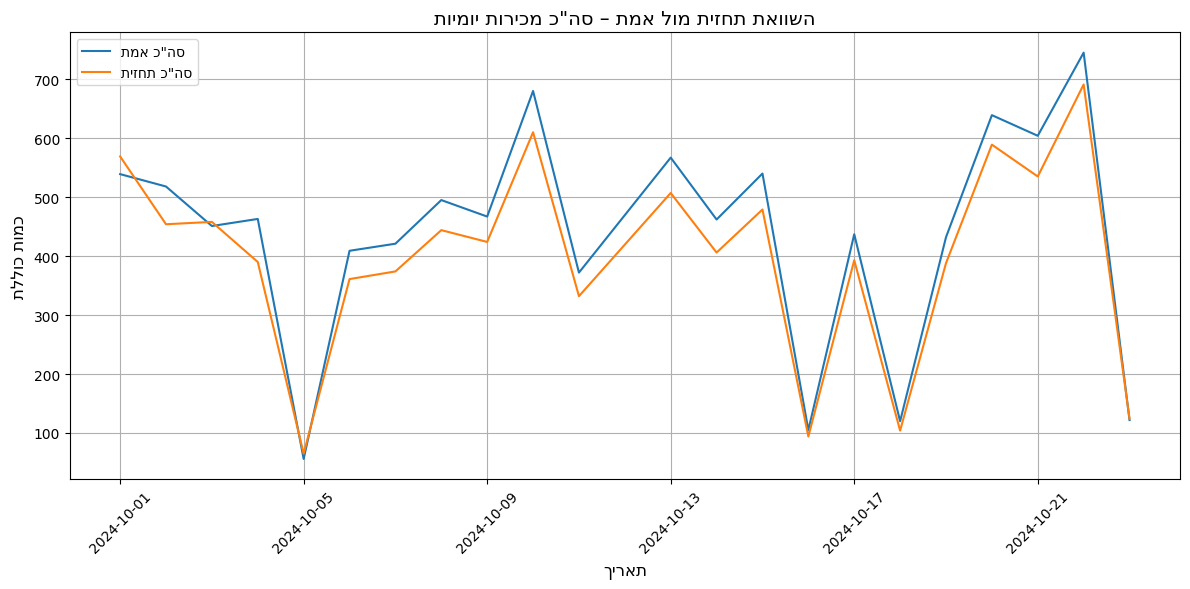

In [91]:
import seaborn as sns

plt.rcParams["font.family"] = "DejaVu Sans"
def rtl(text):
    return text[::-1]

daily_summary = eval_df.groupby("date").agg({
    "Actual": "sum",
    "Predicted": "sum"
}).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_summary, x="date", y="Actual", label=rtl("סה\"כ אמת"))
sns.lineplot(data=daily_summary, x="date", y="Predicted", label=rtl("סה\"כ תחזית"))

plt.title(rtl("השוואת תחזית מול אמת – סה\"כ מכירות יומיות"), fontsize=14)
plt.xlabel(rtl("תאריך"), fontsize=12)
plt.ylabel(rtl("כמות כוללת"), fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [92]:
eval_df = all_forecasts_eval_df.merge(
    df[["Date", "Clean_Desc_Encoded", "Quantity"]],
    left_on=["date", "Clean_Desc_Encoded"],
    right_on=["Date", "Clean_Desc_Encoded"],
    how="inner"
).rename(columns={"Quantity": "Actual", "Predicted_quantity": "Predicted"})

eval_df = eval_df[eval_df["Actual"] > 0]

eval_df = eval_df.merge(desc_encoding_map, on="Clean_Desc_Encoded", how="left")
eval_df["date"].sort_values().unique()
eval_df.head(30)

,date,predicted_quantity,Clean_Desc_Encoded,predicted_quantity_ceiled,Date,Actual,desc_name
0,2024-10-01,1.017381,0,1.0,2024-10-01,1,ביאנקה 14
1,2024-10-01,1.017381,0,1.0,2024-10-01,1,ביאנקה 14
2,2024-10-01,1.017381,0,1.0,2024-10-01,1,ביאנקה 14
3,2024-10-07,1.008862,0,1.0,2024-10-07,1,ביאנקה 14
4,2024-10-08,1.013682,0,1.0,2024-10-08,1,ביאנקה 14
5,2024-10-08,1.013682,0,1.0,2024-10-08,1,ביאנקה 14
6,2024-10-08,1.013682,0,1.0,2024-10-08,1,ביאנקה 14
7,2024-10-13,1.020036,0,1.0,2024-10-13,1,ביאנקה 14
8,2024-10-13,1.020036,0,1.0,2024-10-13,1,ביאנקה 14
9,2024-10-15,1.012410,0,1.0,2024-10-15,1,ביאנקה 14
